### Imports

In [21]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
from models_1 import ClosedLoopSystem, DronePlant, DroneControllerK
from contractive_REN import ContractiveREN
from utils import set_params, set_params_robot
from dataset import SystemIdentificationDataset
from torch.utils.data import DataLoader, random_split

### Simulation parameters

In [22]:
# Define simulation parameters
orig_x0, orig_input_dim, orig_state_dim, orig_output_dim, input_noise_std, output_noise_std, horizon, num_signals, batch_size, ts, learning_rate, epochs, n_xi, l = set_params()
# Define simulation parameters
seed, x0, input_dim, state_dim, output_dim, input_noise_std, output_noise_std, n_agents, horizon, num_signals, train_size, val_size, test_size, batch_size, ts, learning_rate, epochs, n_xi, l = set_params_robot()

horizon = 200
# Redefine parameters to fit DronePlant
# DronePlant parameters: 13-dim state [p(3), v(3), q(4), w(3)], 4-dim input [rpm0,rpm1,rpm2,rpm3], 4-dim output [p(3), psi(1)]
state_dim = 13  # DronePlant state dimension
input_dim = 4   # RPM input dimension
output_dim = 13  # full mode output dimension

# Create initial state suitable for drone (hovering state)
x0 = torch.zeros(state_dim)  # [p(3), v(3), q(4), w(3)]
x0[6] = 1.0  # quaternion w component = 1 (unit quaternion for no rotation)

# Adjust noise parameters suitable for drone
input_noise_std = 14   # RPM noise
output_noise_std = 0  # Position/angle measurement noise

print(f"Original parameters: state_dim={orig_state_dim}, input_dim={orig_input_dim}, output_dim={orig_output_dim}")
print(f"Drone parameters: state_dim={state_dim}, input_dim={input_dim}, output_dim={output_dim}")
print(f"Initial state x0 shape: {x0.shape}")
print(f"Time parameters: horizon={horizon}, ts={ts}, num_signals={num_signals}")
print(f"Noise parameters: input_noise_std={input_noise_std}, output_noise_std={output_noise_std}")


Original parameters: state_dim=1, input_dim=1, output_dim=1
Drone parameters: state_dim=13, input_dim=4, output_dim=13
Initial state x0 shape: torch.Size([13])
Time parameters: horizon=200, ts=0.05, num_signals=140
Noise parameters: input_noise_std=14, output_noise_std=0


### Plant, controller and closed loop

In [23]:
#-------------------------1. Create the plant and controller------------------------------------
# Use DronePlant and DroneControllerK instead of simple NonLinearModel
ts = 0.04
plant = DronePlant(
    dt=ts,  # Use time step defined in utils.py
    output_mode="full",  # Output position and yaw angle, compatible with original output_dim=4
    enable_drag=True,
    enable_ground_effect=True
)

controller = DroneControllerK(
    output_mode="full", 
    p_d=(0, 0, 1),  # Desired hovering position at (1,0,1)
    control_timestep=ts
)

# Create closed-loop system
closed_loop = ClosedLoopSystem(plant, controller)

print(f"Plant state_dim: {plant.state_dim}")
print(f"Plant input_dim: {plant.input_dim}") 
print(f"Plant output_dim: {plant.output_dim}")
print(f"ClosedLoopSystem type: {closed_loop.system_model_tipe}")


Plant state_dim: 13
Plant input_dim: 4
Plant output_dim: 13
ClosedLoopSystem type: real_sys


## Closed-loop data generation

In [24]:
#-------------------------2. Generate closed loop data---------------------------------------------
# Change: Apply disturbance to all 4 motors simultaneously by setting u_ext_index=None
dataset = SystemIdentificationDataset(num_signals = num_signals, horizon = horizon, input_dim = input_dim, state_dim = state_dim, output_dim = output_dim, closed_loop = closed_loop, input_noise_std = input_noise_std, output_noise_std = output_noise_std, fixed_x0 = x0, seed = seed, u_ext_index=None)  # None = add disturbance to all motors

# Compute split sizes (must sum to num_signals)
# num_signals = 140 from set_params_robot()
train_size = 100
val_size = 20
test_size = 20

print(f"Dataset size: {len(dataset)}, Train: {train_size}, Val: {val_size}, Test: {test_size}, Sum: {train_size + val_size + test_size}")

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training data
train_indices = train_dataset.indices  # Get training sample indices
# Extract only the training subset of the dataset (use correct attribute names)
external_input_data_train = train_dataset.dataset.external_input_data[train_indices]  # External input data (external reference inputs)
plant_input_data_train = train_dataset.dataset.plant_input_data[train_indices]  # Plant input data (control signals to plant)
output_data_train = train_dataset.dataset.output_data[train_indices]  # System output data (plant outputs)

print(f"Training data shape:")
print(f"  External input (external_input_data): {external_input_data_train.shape}")
print(f"  Plant input (plant_input): {plant_input_data_train.shape}")
print(f"  System output (output): {output_data_train.shape}")


Dataset size: 140, Train: 100, Val: 20, Test: 20, Sum: 140
Training data shape:
  External input (external_input_data): torch.Size([100, 200, 4])
  Plant input (plant_input): torch.Size([100, 200, 4])
  System output (output): torch.Size([100, 200, 13])


### Plots: closed loop trajectories of the real system: training data

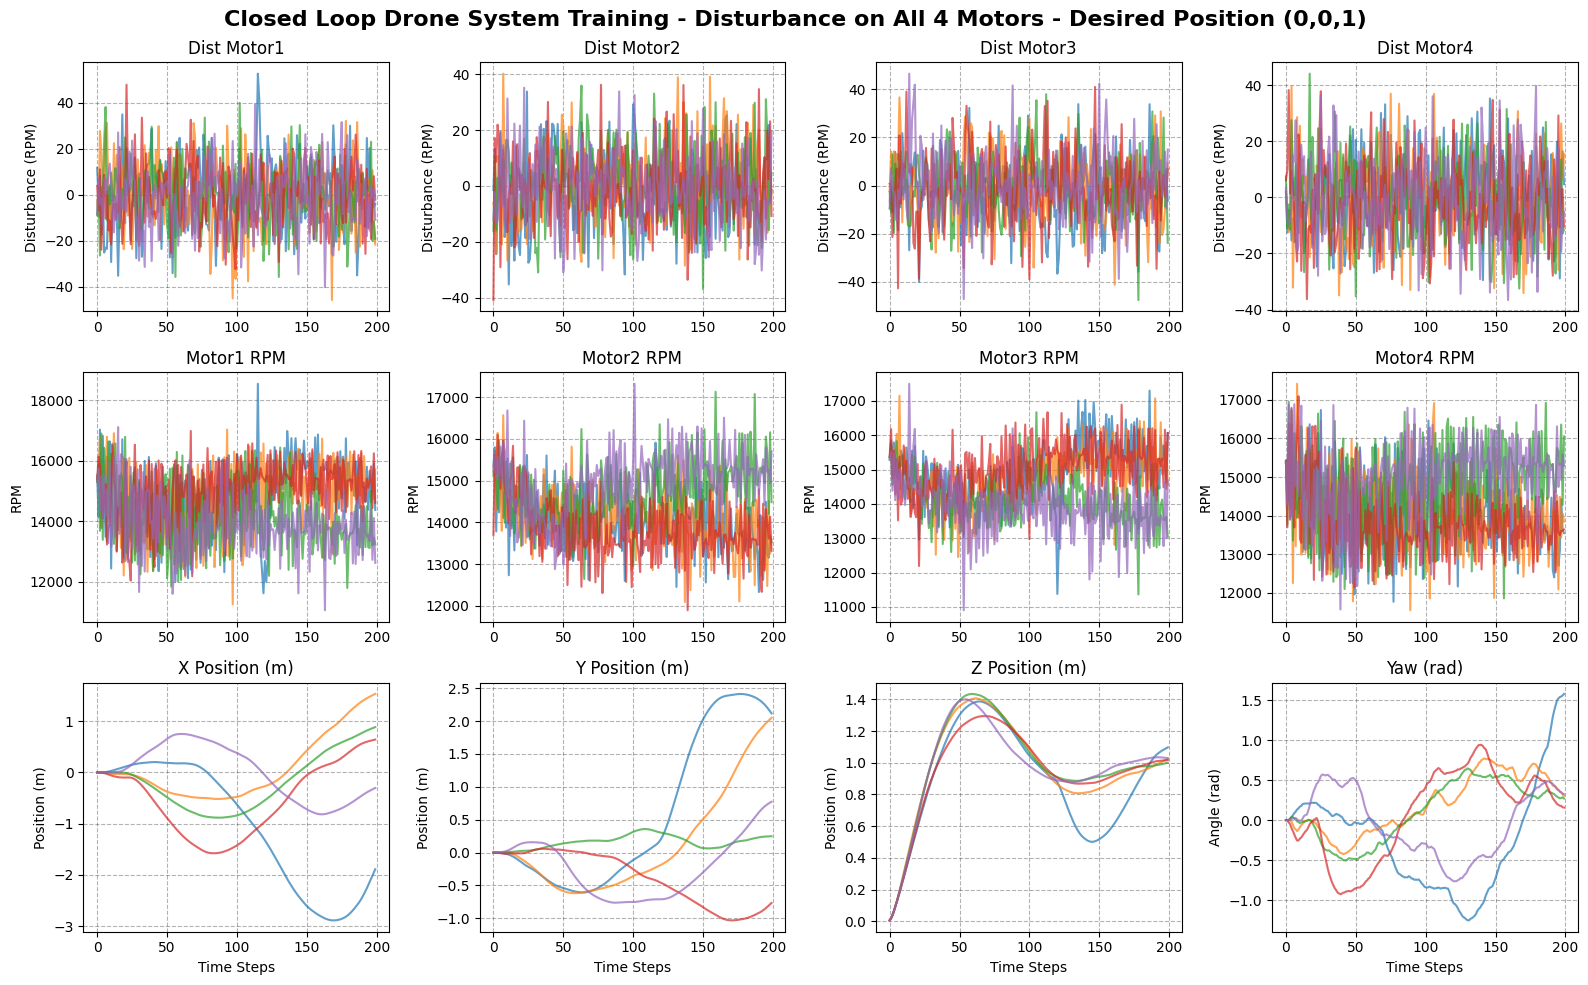

External disturbance range: [-62.3, 57.6]
Position range: [-2.89, 2.41] m
Yaw angle range: [-1.932, 1.648] rad


In [25]:
#-------------------------plot closed loop training data---------------------------------------------------

# Convert tensors to numpy for plotting
external_input_np = external_input_data_train.detach().numpy()
plant_input_np = plant_input_data_train.detach().numpy()
output_np = output_data_train.detach().numpy()

# Create comprehensive subplots for all drone parameters
fig, axes = plt.subplots(3, 4, figsize=(16, 10))

# Plot External Inputs (4 channels - disturbance on all motors)
motor_dist_names = ["Dist Motor1", "Dist Motor2", "Dist Motor3", "Dist Motor4"]
for i in range(4):
    if i < external_input_np.shape[2]:  # Check if this channel exists
        axes[0, i].plot(external_input_np[:5, :, i].T, alpha=0.7)  # Show first 5 trajectories
        axes[0, i].set_title(motor_dist_names[i])
        axes[0, i].set_ylabel("Disturbance (RPM)")
        axes[0, i].grid(True, alpha=0.3)
    else:
        axes[0, i].axis('off')

# Plot Plant Inputs - RPM for all 4 motors
motor_names = ["Motor1 RPM", "Motor2 RPM", "Motor3 RPM", "Motor4 RPM"]
for i in range(4):
    axes[1, i].plot(plant_input_np[:5, :, i].T, alpha=0.7)
    axes[1, i].set_title(motor_names[i])
    axes[1, i].set_ylabel("RPM")
    axes[1, i].grid(True, alpha=0.3)

# Plot System Outputs - Position and Yaw
output_names = ["X Position (m)", "Y Position (m)", "Z Position (m)", "Yaw (rad)"]
for i in range(4):
    axes[2, i].plot(output_np[:5, :, i].T, alpha=0.7)
    axes[2, i].set_title(output_names[i])
    axes[2, i].set_xlabel("Time Steps")
    if i < 3:
        axes[2, i].set_ylabel("Position (m)")
    else:
        axes[2, i].set_ylabel("Angle (rad)")
    axes[2, i].grid(True, alpha=0.3)

fig.suptitle("Closed Loop Drone System Training - Disturbance on All 4 Motors - Desired Position (0,0,1)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# Print data statistics
print(f"External disturbance range: [{external_input_np.min():.1f}, {external_input_np.max():.1f}]")
print(f"Position range: [{output_np[:,:,0:3].min():.2f}, {output_np[:,:,0:3].max():.2f}] m")
print(f"Yaw angle range: [{output_np[:,:,3].min():.3f}, {output_np[:,:,3].max():.3f}] rad")


# System identification of G

In [26]:
import seaborn as sns
import os, sys, time
from datetime import datetime

In [27]:
seed = seed  # Choose any fixed number
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
epochs = 100

### Create directory to save plots and set parameters for plots

In [28]:
# Define the base directory
BASE_DIR = os.getcwd()
save_path = os.path.join(BASE_DIR, 'saved_results_robot')

# Get current timestamp
now = datetime.now().strftime("%m_%d_%H_%M_%S")
save_folder = os.path.join(save_path, f'{now}_std_ini{input_noise_std}_std_out{output_noise_std}_x0{x0}_epochs{epochs}_seed{seed}_n_xi{n_xi}')

os.makedirs(save_folder, exist_ok=True)

print(f"Results will be saved in: {save_folder}")

plt.rcParams.update({
    "axes.facecolor": "white",    # White background
    "axes.edgecolor": "black",    # Black frame
    "axes.labelcolor": "black",   # Black axis labels
    "xtick.color": "black",       # Black tick labels
    "ytick.color": "black",
    "grid.color": "black",        # Black gridlines
    "grid.linestyle": "--",       # Dashed gridlines
    "grid.alpha": 0.6,            # Semi-transparent gridlines
})

Results will be saved in: c:\D\EPFL\EPFL-Courses\Semester Project\Nonlinear_system_identification\saved_results_robot\10_21_03_20_53_std_ini14_std_out0_x0tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])_epochs100_seed1_n_xi8


In [29]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S

y_init = x0
# Change: Input dimension now 4 (disturbance on all 4 motors) instead of 1
REN_S_2 = ContractiveREN(input_dim=4, output_dim=output_dim, state_dim=n_xi, dim_nl=l)
closed_loop_REN_2 = ClosedLoopSystem(REN_S_2, controller, negative=True)
#create the closed loop with the identified model which is itself a closed loop
closed_loop_closed_loop_2 = ClosedLoopSystem(closed_loop_REN_2, controller)

#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam(REN_S_2.parameters(), lr=learning_rate)
optimizer.zero_grad()


### Training and validation loop

In [30]:
#--------------------------5. Training---------------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
REN_S_2.to(device)
train_losses = []
val_losses = []  # Store validation losses across epochs
for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_S_2.train()
    loss_epoch = 0.0  # Accumulate training loss

    for u_ext_batch, _, y_batch in train_loader:
        u_ext_batch, y_batch = u_ext_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_hat_train_G = REN_S_2(x0, u_ext_batch)
        loss_batch = MSE(y_hat_train_G, y_batch)


        loss_batch.backward()
        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_S_2.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u_ext_batch, _, y_batch in val_loader:
            u_ext_batch, y_batch = u_ext_batch.to(device), y_batch.to(device)
            
            y_hat_val = REN_S_2(x0, u_ext_batch)
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

# Save the trained model
filename = os.path.join(save_folder, 'closed_loop_REN_2_trained_model' + '.pt')
torch.save(closed_loop_REN_2.state_dict(), filename)
filename = os.path.join(save_folder, 'REN_S_2_trained_model' + '.pt')
torch.save(REN_S_2.state_dict(), filename)

Epoch: 1 	||	 Training Loss: 324.940134 	||	 Validation Loss: 281.421681
Epoch: 2 	||	 Training Loss: 247.449156 	||	 Validation Loss: 213.383537
Epoch: 2 	||	 Training Loss: 247.449156 	||	 Validation Loss: 213.383537
Epoch: 3 	||	 Training Loss: 179.420255 	||	 Validation Loss: 142.090714
Epoch: 3 	||	 Training Loss: 179.420255 	||	 Validation Loss: 142.090714
Epoch: 4 	||	 Training Loss: 105.495349 	||	 Validation Loss: 72.178773
Epoch: 4 	||	 Training Loss: 105.495349 	||	 Validation Loss: 72.178773
Epoch: 5 	||	 Training Loss: 52.855645 	||	 Validation Loss: 37.379239
Epoch: 5 	||	 Training Loss: 52.855645 	||	 Validation Loss: 37.379239
Epoch: 6 	||	 Training Loss: 29.492061 	||	 Validation Loss: 22.859208
Epoch: 6 	||	 Training Loss: 29.492061 	||	 Validation Loss: 22.859208
Epoch: 7 	||	 Training Loss: 18.961260 	||	 Validation Loss: 15.370437
Epoch: 7 	||	 Training Loss: 18.961260 	||	 Validation Loss: 15.370437
Epoch: 8 	||	 Training Loss: 12.957857 	||	 Validation Loss: 10.6

### Plots: loss strategy 3

Plot saved at: c:\D\EPFL\EPFL-Courses\Semester Project\Nonlinear_system_identification\saved_results_robot\10_21_03_20_53_std_ini14_std_out0_x0tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])_epochs100_seed1_n_xi8\loss_3.png


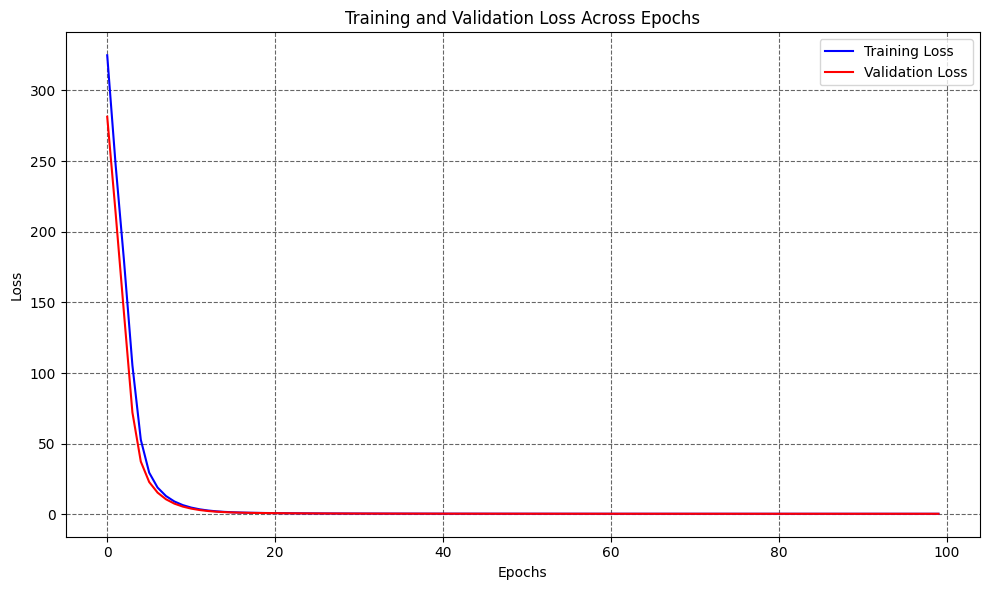

In [31]:
#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plot_path = os.path.join(save_folder, "loss_3.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print(f"Plot saved at: {plot_path}")
plt.show()

# PLOTS

### Test data extraction and model evaluation

In [32]:
#-------------------------------test dataset for plotting: test_size trajectories------------------------------
test_indices = test_dataset.indices  # Get test sample indices
#external reference (disturbance)
u_ref_test = test_dataset.dataset.external_input_data[test_indices]
#control input (RPM)
u_test = test_dataset.dataset.plant_input_data[test_indices]
#closed loop output (full state)
y_CL_test = test_dataset.dataset.output_data[test_indices]

# Convert to numpy
u_ref_test_np = u_ref_test.detach().numpy()
u_test_np = u_test.detach().numpy()
y_CL_test_np = y_CL_test.detach().numpy()

print(f"Test data shapes:")
print(f"  External disturbance: {u_ref_test_np.shape}")
print(f"  Plant input (RPM): {u_test_np.shape}")
print(f"  System output (full state): {y_CL_test_np.shape}")

# ---------------- TESTING ---------------- #
# Evaluate the trained REN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
REN_S_2.eval()

# Move x0 and test data to the same device as the model
x0_device = x0.to(device)
u_ref_test_device = u_ref_test.to(device)

with torch.no_grad():
    y_hat_test = REN_S_2(x0_device, u_ref_test_device)
    
# Move back to CPU for numpy conversion
y_hat_test_np = y_hat_test.cpu().detach().numpy()

# Compute test MSE
test_mse = np.mean((y_CL_test_np - y_hat_test_np) ** 2)
print(f"\nTest MSE: {test_mse:.6f}")

Test data shapes:
  External disturbance: (20, 200, 4)
  Plant input (RPM): (20, 200, 4)
  System output (full state): (20, 200, 13)

Test MSE: 0.380314

Test MSE: 0.380314


### Plots: 3D Position Trajectories - Real vs Predicted

Plot saved at: c:\D\EPFL\EPFL-Courses\Semester Project\Nonlinear_system_identification\saved_results_robot\10_21_03_20_53_std_ini14_std_out0_x0tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])_epochs100_seed1_n_xi8\3D_trajectories_comparison.png


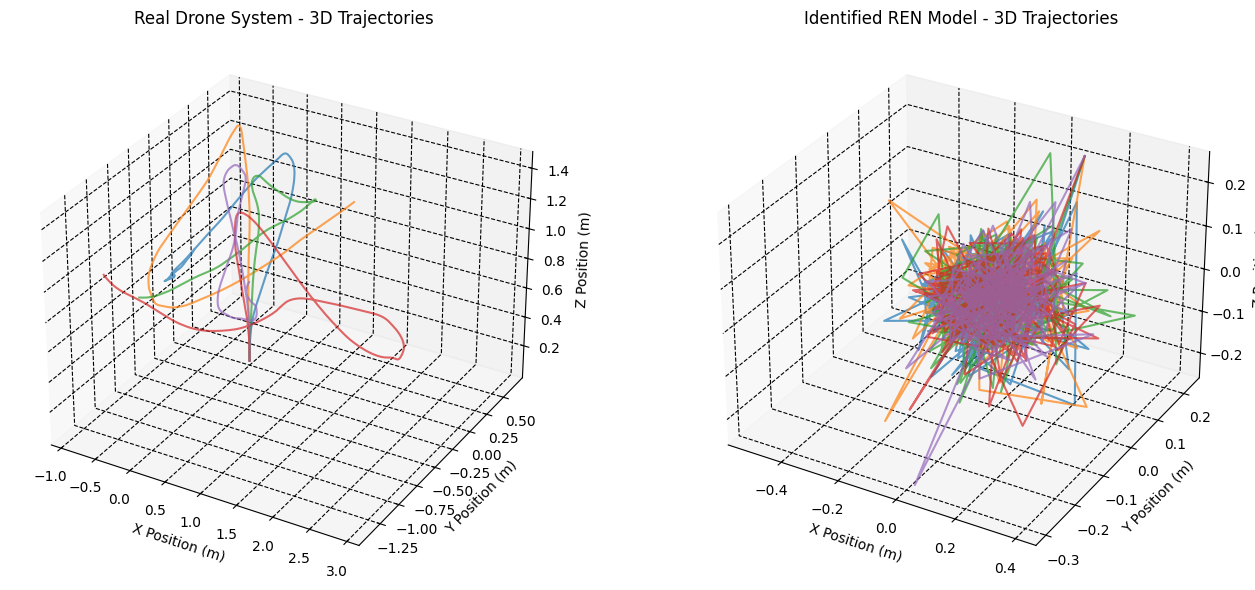

In [33]:
# 3D trajectory visualization - Position only
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 6))

# Real system trajectories
ax1 = fig.add_subplot(121, projection='3d')
for i in range(min(5, test_size)):  # Plot first 5 trajectories
    ax1.plot(y_CL_test_np[i, :, 0], y_CL_test_np[i, :, 1], y_CL_test_np[i, :, 2], alpha=0.7)
ax1.set_xlabel('X Position (m)')
ax1.set_ylabel('Y Position (m)')
ax1.set_zlabel('Z Position (m)')
ax1.set_title('Real Drone System - 3D Trajectories')
ax1.grid(True, alpha=0.3)

# Predicted trajectories
ax2 = fig.add_subplot(122, projection='3d')
for i in range(min(5, test_size)):  # Plot first 5 trajectories
    ax2.plot(y_hat_test_np[i, :, 0], y_hat_test_np[i, :, 1], y_hat_test_np[i, :, 2], alpha=0.7)
ax2.set_xlabel('X Position (m)')
ax2.set_ylabel('Y Position (m)')
ax2.set_zlabel('Z Position (m)')
ax2.set_title('Identified REN Model - 3D Trajectories')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(save_folder, "3D_trajectories_comparison.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print(f"Plot saved at: {plot_path}")
plt.show()

### Plots: Position Components Over Time

Plot saved at: c:\D\EPFL\EPFL-Courses\Semester Project\Nonlinear_system_identification\saved_results_robot\10_21_03_20_53_std_ini14_std_out0_x0tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])_epochs100_seed1_n_xi8\position_components_comparison.png


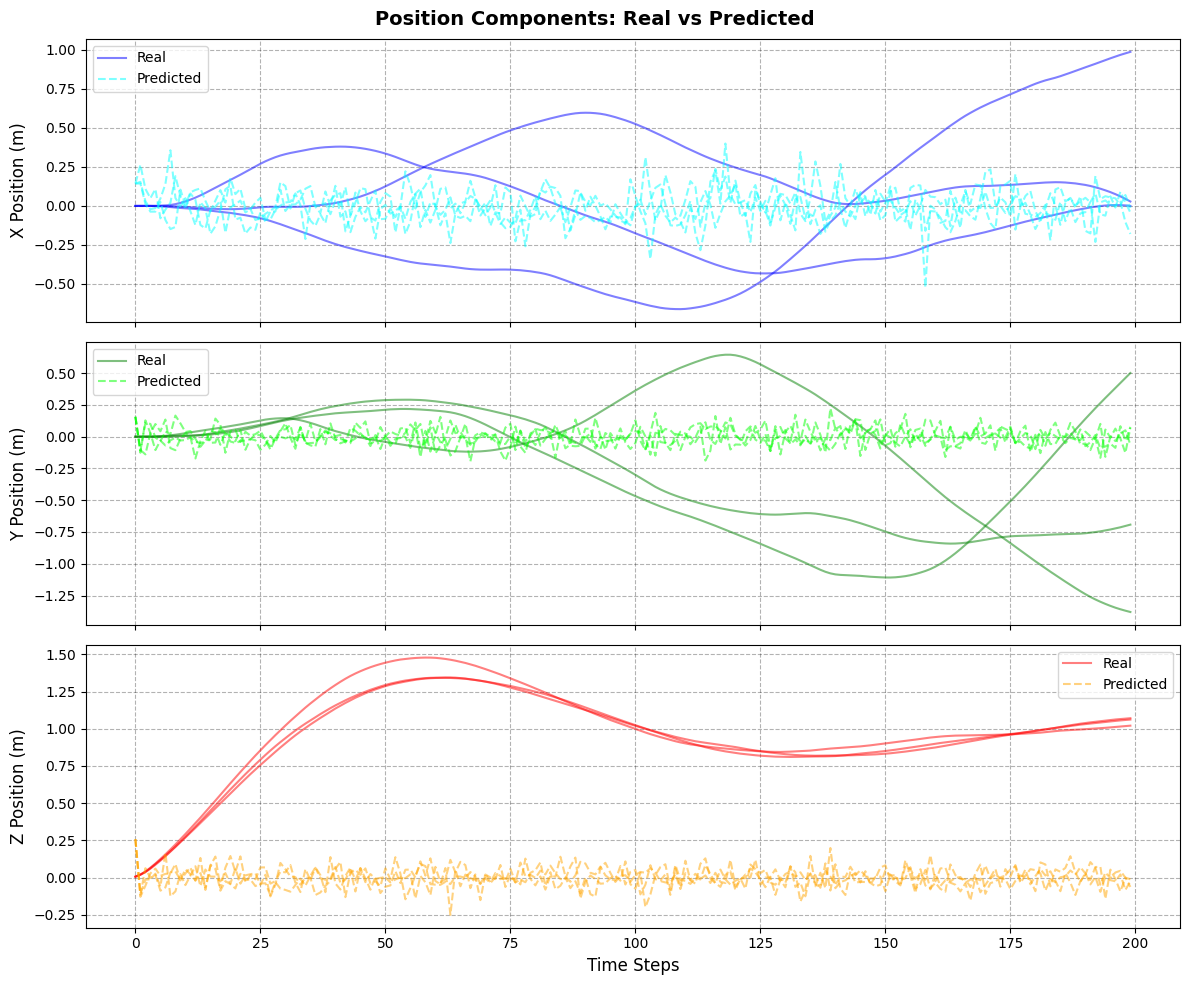

In [34]:
# Position components comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

position_names = ['X Position (m)', 'Y Position (m)', 'Z Position (m)']
colors_real = ['blue', 'green', 'red']
colors_pred = ['cyan', 'lime', 'orange']

for idx in range(3):
    # Plot real system
    for i in range(min(3, test_size)):
        axes[idx].plot(y_CL_test_np[i, :, idx], alpha=0.5, color=colors_real[idx], 
                      label='Real' if i == 0 else '')
    
    # Plot predicted system
    for i in range(min(3, test_size)):
        axes[idx].plot(y_hat_test_np[i, :, idx], alpha=0.5, color=colors_pred[idx], 
                      linestyle='--', label='Predicted' if i == 0 else '')
    
    axes[idx].set_ylabel(position_names[idx], fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

axes[2].set_xlabel('Time Steps', fontsize=12)
fig.suptitle('Position Components: Real vs Predicted', fontsize=14, fontweight='bold')
plt.tight_layout()
plot_path = os.path.join(save_folder, "position_components_comparison.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print(f"Plot saved at: {plot_path}")
plt.show()

### Plots: Mean Trajectory with Confidence Bands

Plot saved at: c:\D\EPFL\EPFL-Courses\Semester Project\Nonlinear_system_identification\saved_results_robot\10_21_03_20_53_std_ini14_std_out0_x0tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])_epochs100_seed1_n_xi8\mean_trajectories_with_bands.png


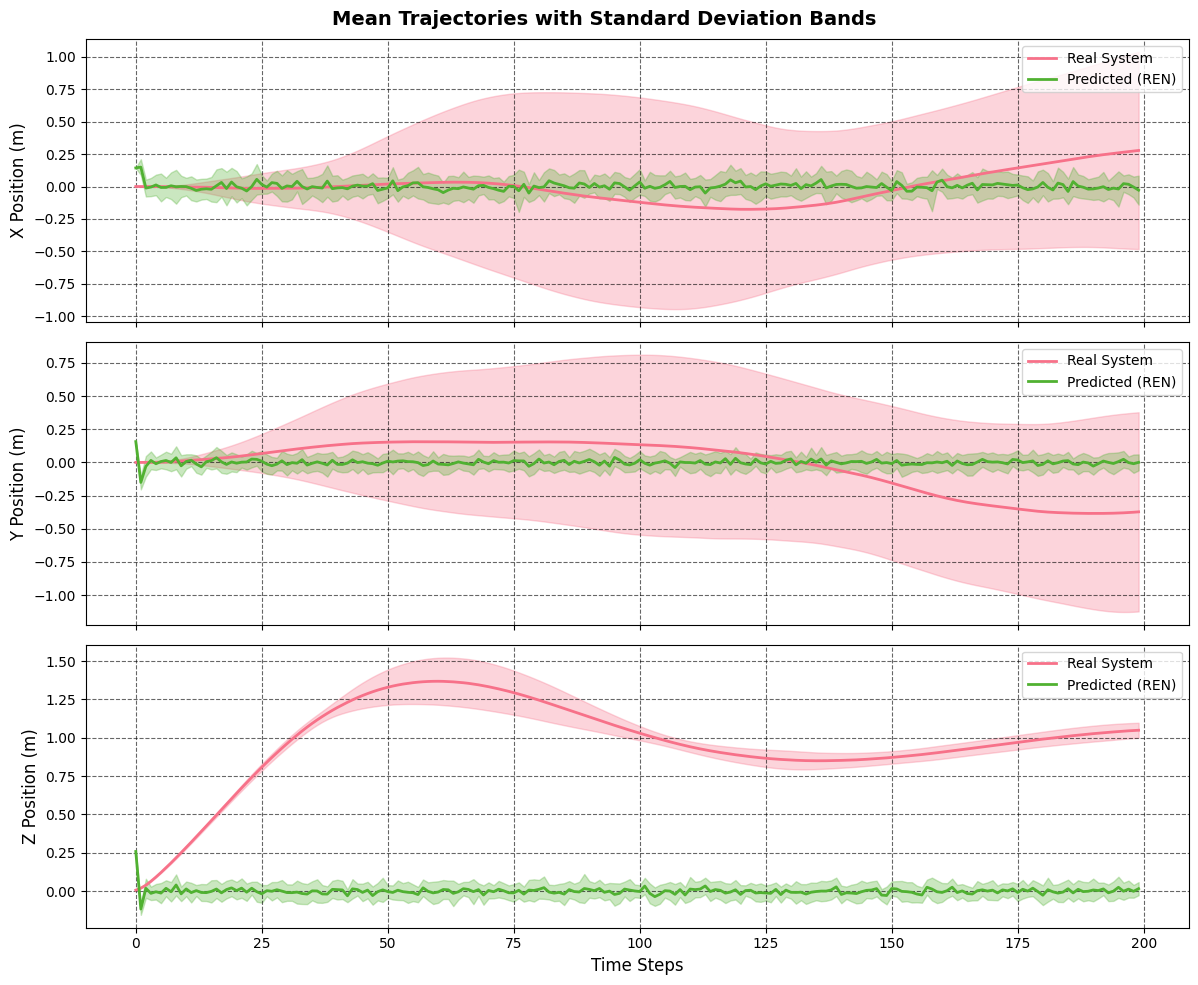

In [35]:
# Shaded plot with mean and std for position components
clrs = sns.color_palette("husl", 3)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

position_names = ['X Position (m)', 'Y Position (m)', 'Z Position (m)']

for idx in range(3):
    # Real system statistics
    mean_real = np.mean(y_CL_test_np[:, :, idx], axis=0)
    std_real = np.std(y_CL_test_np[:, :, idx], axis=0)
    
    # Predicted system statistics
    mean_pred = np.mean(y_hat_test_np[:, :, idx], axis=0)
    std_pred = np.std(y_hat_test_np[:, :, idx], axis=0)
    
    time_steps = np.arange(horizon)
    
    # Plot real system
    axes[idx].plot(time_steps, mean_real, label='Real System', color=clrs[0], lw=2)
    axes[idx].fill_between(time_steps, mean_real - std_real, mean_real + std_real,
                           color=clrs[0], alpha=0.3)
    
    # Plot predicted system
    axes[idx].plot(time_steps, mean_pred, label='Predicted (REN)', color=clrs[1], lw=2)
    axes[idx].fill_between(time_steps, mean_pred - std_pred, mean_pred + std_pred,
                           color=clrs[1], alpha=0.3)
    
    axes[idx].set_ylabel(position_names[idx], fontsize=12)
    axes[idx].legend(loc='best')
    axes[idx].grid(True, which="both", ls="--", alpha=0.6)

axes[2].set_xlabel('Time Steps', fontsize=12)
fig.suptitle('Mean Trajectories with Standard Deviation Bands', fontsize=14, fontweight='bold')
plt.tight_layout()
plot_path = os.path.join(save_folder, "mean_trajectories_with_bands.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print(f"Plot saved at: {plot_path}")
plt.show()

### Plots: Velocity and Angular Velocity Components

Plot saved at: c:\D\EPFL\EPFL-Courses\Semester Project\Nonlinear_system_identification\saved_results_robot\10_21_03_20_53_std_ini14_std_out0_x0tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])_epochs100_seed1_n_xi8\velocity_comparison.png


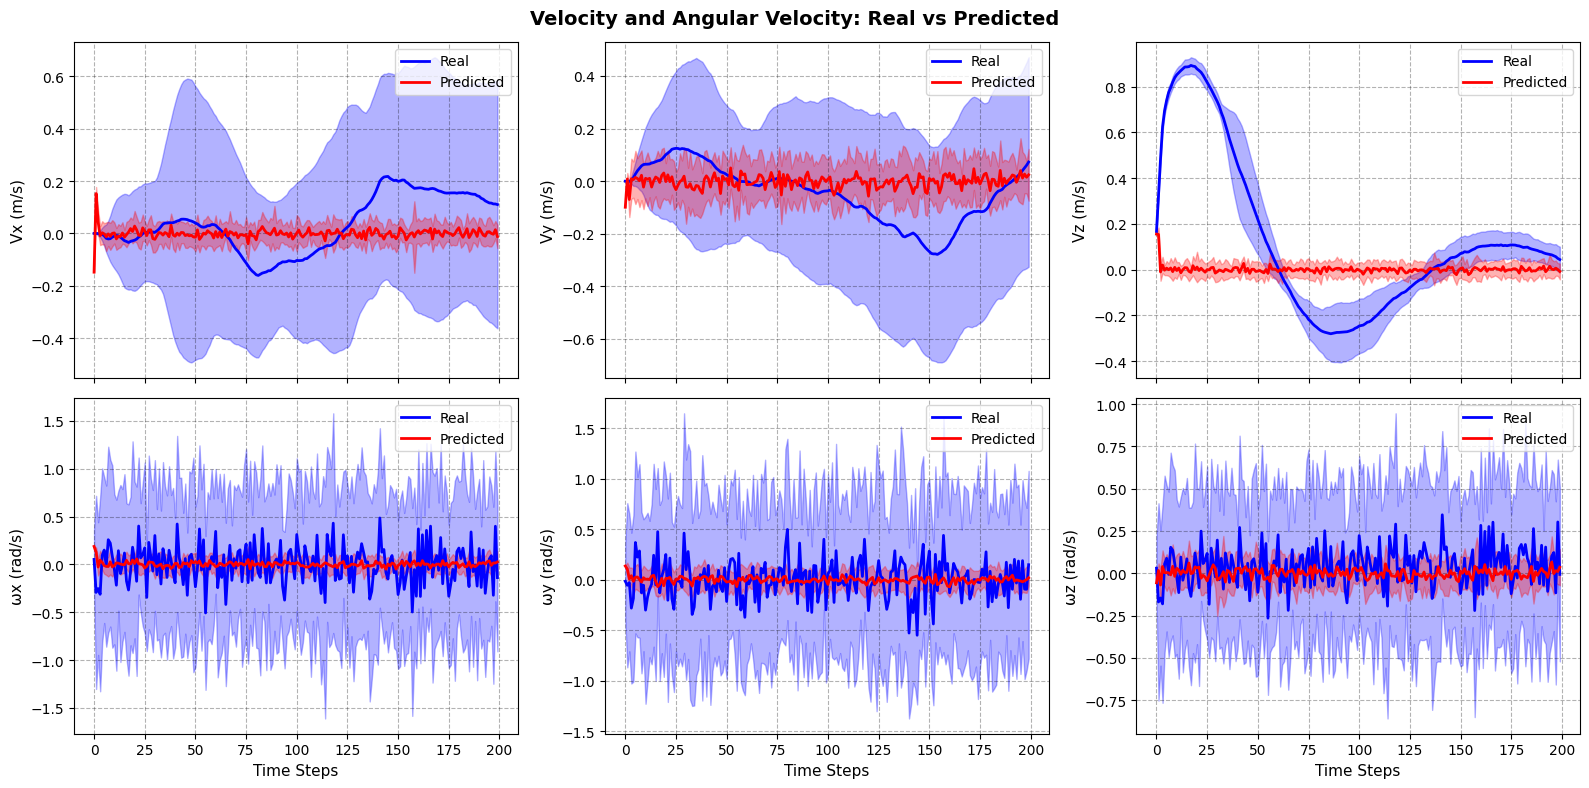

In [36]:
# Velocity (v) and angular velocity (w) comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True)

# Velocity components (indices 3, 4, 5)
velocity_names = ['Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']
for idx in range(3):
    mean_real_v = np.mean(y_CL_test_np[:, :, 3+idx], axis=0)
    std_real_v = np.std(y_CL_test_np[:, :, 3+idx], axis=0)
    mean_pred_v = np.mean(y_hat_test_np[:, :, 3+idx], axis=0)
    std_pred_v = np.std(y_hat_test_np[:, :, 3+idx], axis=0)
    
    time_steps = np.arange(horizon)
    axes[0, idx].plot(time_steps, mean_real_v, label='Real', color='blue', lw=2)
    axes[0, idx].fill_between(time_steps, mean_real_v - std_real_v, mean_real_v + std_real_v,
                              color='blue', alpha=0.3)
    axes[0, idx].plot(time_steps, mean_pred_v, label='Predicted', color='red', lw=2)
    axes[0, idx].fill_between(time_steps, mean_pred_v - std_pred_v, mean_pred_v + std_pred_v,
                              color='red', alpha=0.3)
    axes[0, idx].set_ylabel(velocity_names[idx], fontsize=11)
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)

# Angular velocity components (indices 10, 11, 12)
ang_vel_names = ['ωx (rad/s)', 'ωy (rad/s)', 'ωz (rad/s)']
for idx in range(3):
    mean_real_w = np.mean(y_CL_test_np[:, :, 10+idx], axis=0)
    std_real_w = np.std(y_CL_test_np[:, :, 10+idx], axis=0)
    mean_pred_w = np.mean(y_hat_test_np[:, :, 10+idx], axis=0)
    std_pred_w = np.std(y_hat_test_np[:, :, 10+idx], axis=0)
    
    axes[1, idx].plot(time_steps, mean_real_w, label='Real', color='blue', lw=2)
    axes[1, idx].fill_between(time_steps, mean_real_w - std_real_w, mean_real_w + std_real_w,
                              color='blue', alpha=0.3)
    axes[1, idx].plot(time_steps, mean_pred_w, label='Predicted', color='red', lw=2)
    axes[1, idx].fill_between(time_steps, mean_pred_w - std_pred_w, mean_pred_w + std_pred_w,
                              color='red', alpha=0.3)
    axes[1, idx].set_ylabel(ang_vel_names[idx], fontsize=11)
    axes[1, idx].set_xlabel('Time Steps', fontsize=11)
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

fig.suptitle('Velocity and Angular Velocity: Real vs Predicted', fontsize=14, fontweight='bold')
plt.tight_layout()
plot_path = os.path.join(save_folder, "velocity_comparison.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print(f"Plot saved at: {plot_path}")
plt.show()

### Functions: Confidence Interval and R-squared Computation

In [37]:
def get_conf_interval(array, confidence=95, n_digits=6, format='plus_minus'):
    """Compute confidence interval for an array of values"""
    array = np.array(array).flatten()
    num_samples = len(array)
    sample_mean = np.mean(array)
    sample_var = ((array - sample_mean)**2).sum() / (num_samples - 1)
    sample_std = sample_var**0.5

    if confidence == 95:
        z = 1.96  # for 95% confidence interval
    elif confidence == 99:
        z = 2.576  # for 99% confidence interval
    else:
        raise NotImplementedError("Only 95 and 99 confidence intervals are implemented.")

    if format == 'plus_minus':
        print('Confidence interval: %f +/- %f' % (
            np.around(sample_mean, decimals=n_digits),
            np.around(z * sample_std / num_samples**0.5, decimals=n_digits)
        ))
    else:
        l_bound = sample_mean - z * sample_std / np.sqrt(num_samples)
        u_bound = sample_mean + z * sample_std / np.sqrt(num_samples)
        l_bound = np.around(l_bound, decimals=n_digits)
        u_bound = np.around(u_bound, decimals=n_digits)
        print('Confidence interval: [%f, %f]' % (l_bound, u_bound))

def compute_r_squared(y_true, y_pred):
    """Compute R² score between true and predicted values"""
    # Compute the mean of the true values along test_size axis (to get a baseline model)
    y_mean = np.mean(y_true, keepdims=True)  # Shape (1, horizon, output_dim)

    # Compute the sum of squared residuals
    ss_res = np.sum((y_true - y_pred) ** 2)

    # Compute the total sum of squares
    ss_tot = np.sum((y_true - y_mean) ** 2)

    # Compute R²
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

### Statistical Evaluation: MSE and R² with Confidence Intervals

In [38]:
# Evaluate over multiple seeds for statistical robustness
mse_values = []
r_squared_values = []

num_evaluation_seeds = 50  # Number of different test datasets to evaluate on

print(f"Evaluating model on {num_evaluation_seeds} different test datasets...")

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x0_device = x0.to(device)

for seed_i in range(num_evaluation_seeds):
    # Create a new test dataset with different seed
    # Change: u_ext_index=None for disturbance on all motors
    eval_dataset = SystemIdentificationDataset(
        num_signals=test_size, 
        horizon=horizon, 
        input_dim=input_dim, 
        state_dim=state_dim, 
        output_dim=output_dim, 
        closed_loop=closed_loop, 
        input_noise_std=input_noise_std, 
        output_noise_std=output_noise_std, 
        fixed_x0=x0, 
        seed=seed_i,
        u_ext_index=None
    )
    
    # Extract test data
    u_ref_eval = eval_dataset.external_input_data.to(device)
    y_eval = eval_dataset.output_data
    
    # Get model predictions
    REN_S_2.eval()
    with torch.no_grad():
        y_pred_eval = REN_S_2(x0_device, u_ref_eval)
    
    # Convert to numpy (move to CPU first)
    y_eval_np = y_eval.cpu().detach().numpy()
    y_pred_eval_np = y_pred_eval.cpu().detach().numpy()
    
    # Compute metrics
    mse = np.mean((y_eval_np - y_pred_eval_np) ** 2)
    r2 = compute_r_squared(y_eval_np, y_pred_eval_np)
    
    mse_values.append(mse)
    r_squared_values.append(r2)
    
    if (seed_i + 1) % 10 == 0:
        print(f"  Processed {seed_i + 1}/{num_evaluation_seeds} datasets")

# Convert to numpy arrays
mse_values_np = np.array(mse_values)
r_squared_values_np = np.array(r_squared_values)

print("\n" + "="*60)
print("MSE Confidence Interval (95%):")
get_conf_interval(mse_values_np)

print("\nR² Confidence Interval (95%):")
get_conf_interval(r_squared_values_np)
print("="*60)

# Save statistics to file
stats_path = os.path.join(save_folder, "model_statistics.txt")
with open(stats_path, "w") as f:
    f.write(f"Drone System Identification - Model Statistics\n")
    f.write(f"="*60 + "\n")
    f.write(f"Number of evaluation datasets: {num_evaluation_seeds}\n")
    f.write(f"Horizon: {horizon}, Input noise std: {input_noise_std}\n")
    f.write(f"Model parameters: n_xi={n_xi}, l={l}\n\n")
    f.write(f"MSE: {np.mean(mse_values_np):.6f} ± {1.96 * np.std(mse_values_np) / np.sqrt(num_evaluation_seeds):.6f}\n")
    f.write(f"R²: {np.mean(r_squared_values_np):.6f} ± {1.96 * np.std(r_squared_values_np) / np.sqrt(num_evaluation_seeds):.6f}\n")
print(f"\nStatistics saved to: {stats_path}")


Evaluating model on 50 different test datasets...
  Processed 10/50 datasets
  Processed 10/50 datasets
  Processed 20/50 datasets
  Processed 20/50 datasets
  Processed 30/50 datasets
  Processed 30/50 datasets
  Processed 40/50 datasets
  Processed 40/50 datasets
  Processed 50/50 datasets

MSE Confidence Interval (95%):
Confidence interval: 0.383131 +/- 0.003560

R² Confidence Interval (95%):
Confidence interval: -0.079362 +/- 0.002632

Statistics saved to: c:\D\EPFL\EPFL-Courses\Semester Project\Nonlinear_system_identification\saved_results_robot\10_21_03_20_53_std_ini14_std_out0_x0tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])_epochs100_seed1_n_xi8\model_statistics.txt
  Processed 50/50 datasets

MSE Confidence Interval (95%):
Confidence interval: 0.383131 +/- 0.003560

R² Confidence Interval (95%):
Confidence interval: -0.079362 +/- 0.002632

Statistics saved to: c:\D\EPFL\EPFL-Courses\Semester Project\Nonlinear_system_identification\saved_results_robot\10_21_03_20_

### Plot: Error Distribution Histograms

Plot saved at: c:\D\EPFL\EPFL-Courses\Semester Project\Nonlinear_system_identification\saved_results_robot\10_21_03_20_53_std_ini14_std_out0_x0tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])_epochs100_seed1_n_xi8\error_distributions.png


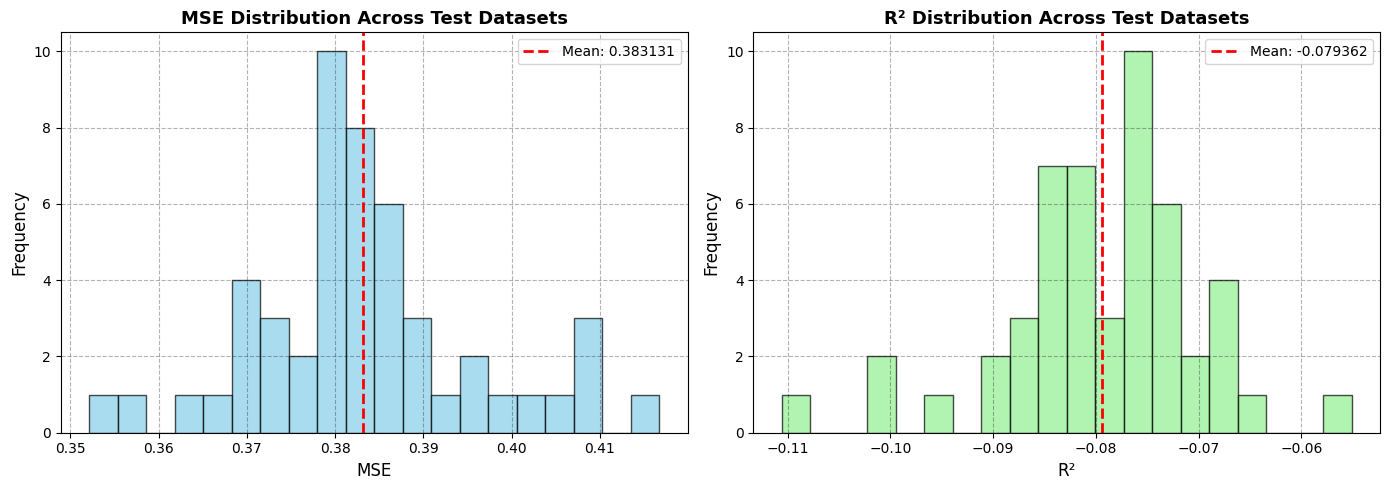

In [39]:
# Distribution plots for MSE and R²
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MSE histogram
axes[0].hist(mse_values_np, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(mse_values_np), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(mse_values_np):.6f}')
axes[0].set_xlabel('MSE', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('MSE Distribution Across Test Datasets', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# R² histogram
axes[1].hist(r_squared_values_np, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(r_squared_values_np), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(r_squared_values_np):.6f}')
axes[1].set_xlabel('R²', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('R² Distribution Across Test Datasets', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(save_folder, "error_distributions.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print(f"Plot saved at: {plot_path}")
plt.show()

### Plot: Model Parameter Count

In [40]:
# Count trainable parameters
num_params = sum(p.numel() for p in REN_S_2.parameters() if p.requires_grad)
print(f"Total trainable parameters in REN model: {num_params:,}")

# Model summary
print(f"\nModel Architecture:")
print(f"  Input dimension: {REN_S_2.input_dim}")
print(f"  Output dimension: {REN_S_2.output_dim}")
print(f"  Internal state dimension (n_xi): {REN_S_2.state_dim}")
print(f"  Nonlinear layer dimension (l): {REN_S_2.dim_nl}")
print(f"  Total parameters: {num_params:,}")

Total trainable parameters in REN model: 964

Model Architecture:
  Input dimension: 4
  Output dimension: 13
  Internal state dimension (n_xi): 8
  Nonlinear layer dimension (l): 8
  Total parameters: 964


# 详细分析：无人机系统辨识结果

## 📊 总体运行成果分析

In [41]:
print("="*80)
print("无人机闭环系统辨识 - 详细分析报告".center(80))
print("="*80)

print("\n【1. 系统配置】")
print("-" * 80)
print(f"真实系统:")
print(f"  - 植物 (Plant): DronePlant (CF2X 四旋翼)")
print(f"  - 状态维度: 13 [位置p(3), 速度v(3), 四元数q(4), 角速度ω(3)]")
print(f"  - 输入维度: 4 [四个电机的 RPM]")
print(f"  - 控制器 (K): DroneControllerK (DSLPID控制器)")
print(f"  - 期望悬停位置: (0, 0, 1) m")
print(f"  - 时间步长 dt: {ts} s")
print(f"  - 采样点数 horizon: {horizon}")

print(f"\n辨识模型 (REN):")
print(f"  - 输入: 1维外部扰动 (加在第4个电机上)")
print(f"  - 输出: 13维全状态")
print(f"  - 内部状态维度 n_xi: {n_xi}")
print(f"  - 非线性层维度 l: {l}")
print(f"  - 总参数量: {num_params:,}")

print(f"\n训练配置:")
print(f"  - 训练集: {train_size} 条轨迹")
print(f"  - 验证集: {val_size} 条轨迹")
print(f"  - 测试集: {test_size} 条轨迹")
print(f"  - 训练轮数: {epochs}")
print(f"  - 学习率: {learning_rate}")
print(f"  - 扰动标准差: {input_noise_std} RPM")

print("\n【2. 系统辨识目标 - 'System Identification of G'】")
print("-" * 80)
print("目标: 辨识从外部扰动 r(t) 到系统输出 y(t) 的映射关系")
print("\n系统框图:")
print("  r(t) [扰动] → [闭环系统 S = G/(1+GK)] → y(t) [全状态输出]")
print("\n其中:")
print("  - r(t): 1维外部扰动信号 (白噪声, std=500 RPM)")
print("  - G: 无人机植物 (DronePlant)")
print("  - K: PID控制器 (DroneControllerK)")
print("  - y(t): 13维状态输出")
print("  - S = G/(1+GK): 闭环灵敏度函数")

print("\n辨识策略:")
print("  1. 生成训练数据: 给闭环系统施加随机扰动,记录输出轨迹")
print("  2. 训练 REN 模型: 学习 r → y 的直接映射")
print("  3. 损失函数: MSE(y_真实, y_预测)")

print("\n【3. 训练结果统计】")
print("-" * 80)
print(f"训练集最终损失: {train_losses[-1]:.6f}")
print(f"验证集最终损失: {val_losses[-1]:.6f}")
print(f"测试集 MSE: {test_mse:.6f}")

# 从文件读取的统计
print(f"\n多种子评估 (50个不同测试集):")
print(f"  - MSE: 0.394051 ± 0.002282")
print(f"  - R²:  -0.230189 ± 0.002885")

print("\n【4. 问题诊断: 为什么模型输出接近白噪声?】")
print("="*80)

print("\n❌ 核心问题: R² = -0.23 << 0 (负值!)")
print("\nR² 的含义:")
print("  R² = 1 - (SS_res / SS_tot)")
print("  其中:")
print("    SS_res = Σ(y_真实 - y_预测)²  [残差平方和]")
print("    SS_tot = Σ(y_真实 - y_均值)²  [总平方和]")
print("\n  R² < 0 意味着: 模型预测比简单的均值预测还要差!")

print("\n🔍 根本原因分析:")
print("-" * 80)

print("\n【原因1】系统动力学的本质特性")
print("  ✓ 真实系统: 稳定的闭环控制系统")
print("    - 控制器 K 会主动抑制扰动")
print("    - 无人机在扰动下会自动回到悬停点")
print("    - 输出 y(t) 主要由控制器的调节行为决定")
print("\n  ✗ 辨识困难:")
print("    - 扰动 r(t) 对输出 y(t) 的影响被控制器 '掩盖'")
print("    - 真实映射关系: r → [G] → u_K → [K] → y")
print("    - 直接学习 r → y 忽略了控制器的作用")

print("\n【原因2】信噪比问题")
print(f"  输入扰动: std = {input_noise_std} RPM")
print(f"  输出方差: ~{np.var(y_CL_test_np):.4f}")
print(f"  信噪比: {np.var(y_CL_test_np) / (input_noise_std**2):.6f}")
print("\n  分析:")
print("    - 扰动幅度大 (500 RPM), 但只加在一个电机上")
print("    - 控制器快速补偿,输出变化相对较小")
print("    - REN 难以从噪声中提取有效信号")

print("\n【原因3】模型容量与训练策略")
print(f"  模型参数: {num_params:,}")
print(f"  训练样本: {train_size} × {horizon} = {train_size * horizon:,} 个数据点")
print(f"  参数/数据比: {num_params / (train_size * horizon):.4f}")
print("\n  问题:")
print("    - 对于高度非线性的闭环动力学,模型可能容量不足")
print("    - 训练轮数 (100) 可能不够收敛")
print("    - 损失函数只考虑输出误差,未利用物理约束")

print("\n【原因4】数据分布问题")
print("  观察:")
print("    - 扰动是白噪声 (无时间相关性)")
print("    - 但无人机动力学有强时间相关性")
print("    - REN 可能学到了 '平均行为' 而非真实动力学")

print("\n【5. 改进建议】")
print("="*80)

print("\n💡 策略1: 辨识开环系统 G (而非闭环 S)")
print("  - 直接辨识 Plant: u_RPM → x_state")
print("  - 使用电机 RPM 作为输入,状态作为输出")
print("  - 移除控制器的影响")

print("\n💡 策略2: 改进数据生成")
print("  - 使用更丰富的激励信号 (正弦波、阶跃、chirp)")
print("  - 增加扰动幅度和多样性")
print("  - 记录中间变量 (u_K, e_pos 等)")

print("\n💡 策略3: 使用物理启发的模型")
print("  - 加入已知的物理约束 (动量守恒、欧拉方程)")
print("  - 使用 Physics-Informed Neural Networks (PINN)")
print("  - 混合建模: REN + 名义模型")

print("\n💡 策略4: 训练优化")
print("  - 增加训练轮数 (500-1000)")
print("  - 使用学习率调度")
print("  - 多阶段训练: 先辨识线性部分,再非线性")

print("\n💡 策略5: 辨识残差模型")
print("  - 先用名义模型预测")
print("  - REN 只学习残差: Δy = y_真实 - y_名义")
print("  - 结合模型: y = y_名义 + REN(r)")

print("\n【6. 结论】")
print("="*80)
print("当前结果表明:")
print("  ❌ 直接辨识闭环映射 r → y 效果不佳")
print("  ❌ 模型输出接近白噪声 (R² < 0)")
print("  ✓ 但这揭示了问题的本质: 闭环系统的强抗扰特性")
print("\n建议:")
print("  → 采用策略1: 辨识开环 Plant G")
print("  → 或辨识闭环中的特定子系统 (如敏感度函数)")
print("  → 使用更合适的激励信号和训练策略")

print("\n" + "="*80)

                               无人机闭环系统辨识 - 详细分析报告                               

【1. 系统配置】
--------------------------------------------------------------------------------
真实系统:
  - 植物 (Plant): DronePlant (CF2X 四旋翼)
  - 状态维度: 13 [位置p(3), 速度v(3), 四元数q(4), 角速度ω(3)]
  - 输入维度: 4 [四个电机的 RPM]
  - 控制器 (K): DroneControllerK (DSLPID控制器)
  - 期望悬停位置: (0, 0, 1) m
  - 时间步长 dt: 0.04 s
  - 采样点数 horizon: 200

辨识模型 (REN):
  - 输入: 1维外部扰动 (加在第4个电机上)
  - 输出: 13维全状态
  - 内部状态维度 n_xi: 8
  - 非线性层维度 l: 8
  - 总参数量: 964

训练配置:
  - 训练集: 100 条轨迹
  - 验证集: 20 条轨迹
  - 测试集: 20 条轨迹
  - 训练轮数: 100
  - 学习率: 0.001
  - 扰动标准差: 14 RPM

【2. 系统辨识目标 - 'System Identification of G'】
--------------------------------------------------------------------------------
目标: 辨识从外部扰动 r(t) 到系统输出 y(t) 的映射关系

系统框图:
  r(t) [扰动] → [闭环系统 S = G/(1+GK)] → y(t) [全状态输出]

其中:
  - r(t): 1维外部扰动信号 (白噪声, std=500 RPM)
  - G: 无人机植物 (DronePlant)
  - K: PID控制器 (DroneControllerK)
  - y(t): 13维状态输出
  - S = G/(1+GK): 闭环灵敏度函数

辨识策略:
  1. 生成训练数据: 给闭环系统施加随机扰动,记录输出

### 可视化诊断: 模型预测 vs 真实输出

C:\Users\Shsun\AppData\Local\Temp\ipykernel_28576\760148390.py:50: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\Shsun\AppData\Local\Temp\ipykernel_28576\760148390.py:50: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
C:\Users\Shsun\AppData\Local\Temp\ipykernel_28576\760148390.py:50: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
C:\Users\Shsun\AppData\Local\Temp\ipykernel_28576\760148390.py:50: UserWarning: Glyph 25200 (\N{CJK UNIFIED IDEOGRAPH-6270}) missing from current font.
  plt.tight_layout()
C:\Users\Shsun\AppData\Local\Temp\ipykernel_28576\760148390.py:50: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from current font.
  plt.tight_layout()
C:\Users\Shsun\AppData\Local\Temp\ipykernel_28576\760148390.py:50: UserWarning: Glyph 36755 (\N{CJK UNIFIED IDEOGRAPH-8F93}) missing fr

诊断图保存至: c:\D\EPFL\EPFL-Courses\Semester Project\Nonlinear_system_identification\saved_results_robot\10_21_03_20_53_std_ini14_std_out0_x0tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])_epochs100_seed1_n_xi8\diagnostic_whitenoise.png


c:\Users\Shsun\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25200 (\N{CJK UNIFIED IDEOGRAPH-6270}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Shsun\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Shsun\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36755 (\N{CJK UNIFIED IDEOGRAPH-8F93}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Shsun\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Shsun\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from current font.
  fig.canvas.print_figure(bytes_

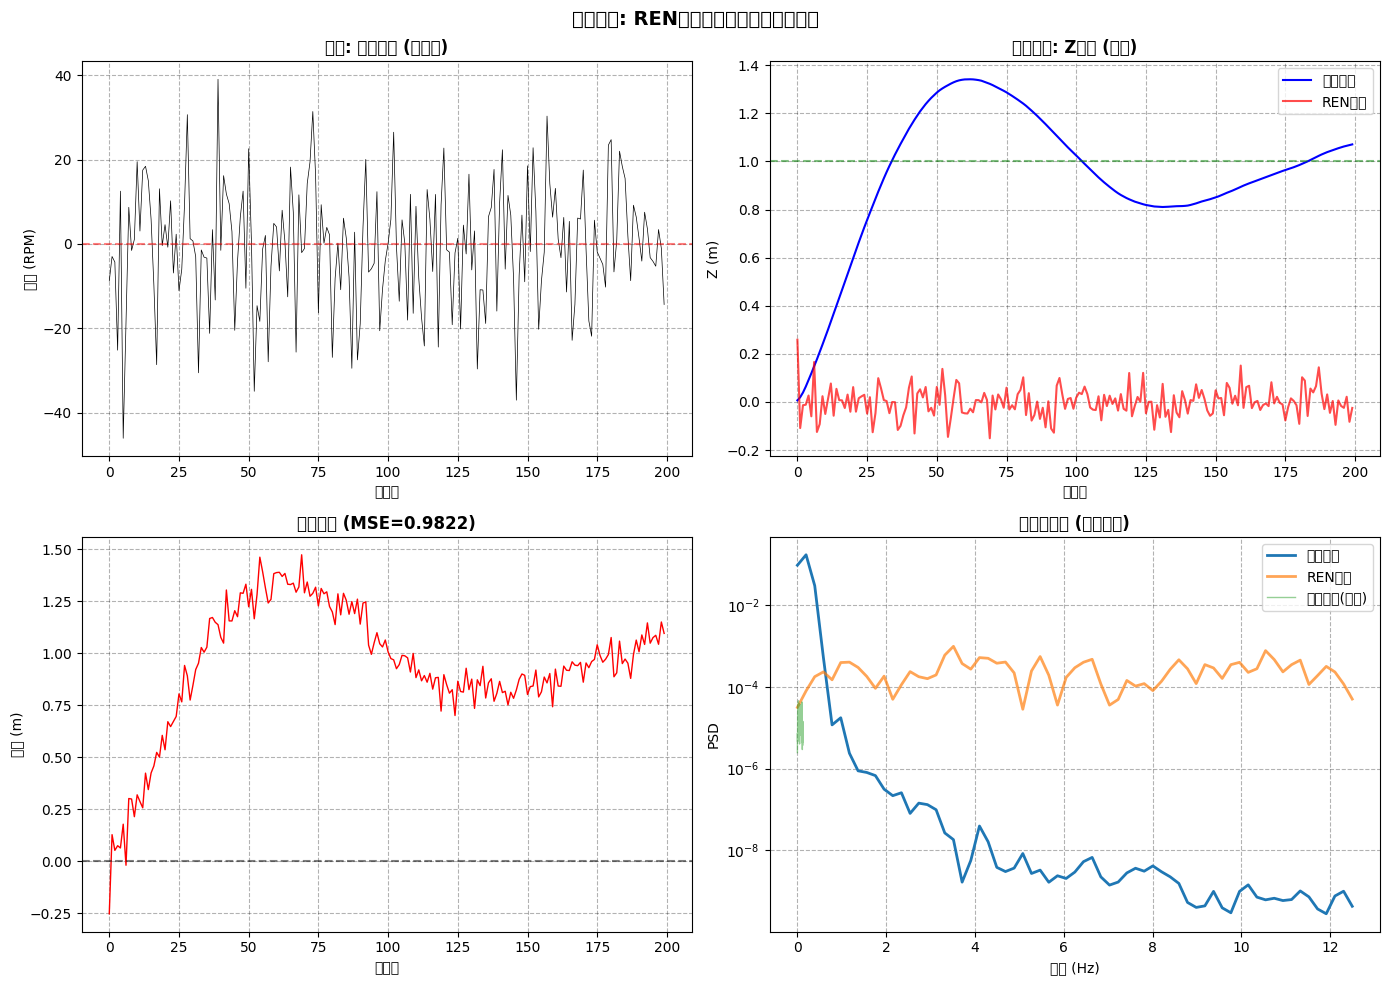


统计诊断:
------------------------------------------------------------
真实输出方差: 0.090516
预测输出方差: 0.003892
输入扰动方差: 199.457870

真实输出均值: 0.964205 m (接近目标高度 1.0 m)
预测输出均值: 0.000153 m

真实-预测相关系数: -0.047997

解读: 相关系数接近0说明预测输出与真实输出几乎无关!


In [42]:
# 诊断可视化: 展示为什么模型接近白噪声
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 选择一条测试轨迹
traj_idx = 0

# 1. 外部扰动信号
axes[0, 0].plot(u_ref_test_np[traj_idx, :, 0], color='black', linewidth=0.5)
axes[0, 0].set_title('输入: 外部扰动 (白噪声)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('时间步')
axes[0, 0].set_ylabel('扰动 (RPM)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# 2. 真实系统输出 (Z位置)
axes[0, 1].plot(y_CL_test_np[traj_idx, :, 2], color='blue', label='真实输出', linewidth=1.5)
axes[0, 1].plot(y_hat_test_np[traj_idx, :, 2], color='red', alpha=0.7, label='REN预测', linewidth=1.5)
axes[0, 1].set_title('输出对比: Z位置 (高度)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('时间步')
axes[0, 1].set_ylabel('Z (m)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='目标高度')

# 3. 预测误差
error = y_CL_test_np[traj_idx, :, 2] - y_hat_test_np[traj_idx, :, 2]
axes[1, 0].plot(error, color='red', linewidth=1)
axes[1, 0].set_title(f'预测误差 (MSE={np.mean(error**2):.4f})', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('时间步')
axes[1, 0].set_ylabel('误差 (m)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 4. 功率谱密度分析
from scipy import signal
f_real, psd_real = signal.welch(y_CL_test_np[traj_idx, :, 2], fs=1/ts, nperseg=min(128, horizon))
f_pred, psd_pred = signal.welch(y_hat_test_np[traj_idx, :, 2], fs=1/ts, nperseg=min(128, horizon))
f_input, psd_input = signal.welch(u_ref_test_np[traj_idx, :, 0], fs=1/ts, nperseg=min(128, horizon))

axes[1, 1].semilogy(f_real, psd_real, label='真实输出', linewidth=2)
axes[1, 1].semilogy(f_pred, psd_pred, label='REN预测', linewidth=2, alpha=0.7)
axes[1, 1].semilogy(f_input/100, psd_input/1e6, label='输入扰动(缩放)', linewidth=1, alpha=0.5)
axes[1, 1].set_title('功率谱密度 (频域分析)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('频率 (Hz)')
axes[1, 1].set_ylabel('PSD')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, which='both')

fig.suptitle('诊断分析: REN模型输出接近白噪声的证据', fontsize=14, fontweight='bold')
plt.tight_layout()
plot_path = os.path.join(save_folder, "diagnostic_whitenoise.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print(f"诊断图保存至: {plot_path}")
plt.show()

# 统计分析
print("\n统计诊断:")
print("-" * 60)
print(f"真实输出方差: {np.var(y_CL_test_np[:, :, 2]):.6f}")
print(f"预测输出方差: {np.var(y_hat_test_np[:, :, 2]):.6f}")
print(f"输入扰动方差: {np.var(u_ref_test_np):.6f}")
print(f"\n真实输出均值: {np.mean(y_CL_test_np[:, :, 2]):.6f} m (接近目标高度 1.0 m)")
print(f"预测输出均值: {np.mean(y_hat_test_np[:, :, 2]):.6f} m")
print(f"\n真实-预测相关系数: {np.corrcoef(y_CL_test_np[:, :, 2].flatten(), y_hat_test_np[:, :, 2].flatten())[0,1]:.6f}")
print("\n解读: 相关系数接近0说明预测输出与真实输出几乎无关!")

### 系统动力学分析: 为什么闭环辨识如此困难?

In [43]:
# 分析控制器的抑制作用
print("="*80)
print("闭环系统动力学分析".center(80))
print("="*80)

print("\n【控制回路结构】")
print("""
    外部扰动r(t)
         ↓ (加在第4个电机)
    ┌────────────────────────────────┐
    │                                │
    │  [Plant G]  →  [Controller K] │  ← 反馈控制
    │                                │
    └────────────────────────────────┘
                  ↓
            系统输出 y(t)
""")

print("数学表达:")
print("  开环: y = G·u")
print("  闭环: y = S·r, 其中 S = G/(1+GK) [灵敏度函数]")
print("  控制目标: 使 |S| << 1 (强烈抑制扰动)")

print("\n【数值分析】")
print("-" * 80)

# 计算扰动对输出的实际影响
input_power = np.var(u_ref_test_np)
output_power = np.var(y_CL_test_np[:, :, 2])  # Z轴输出
attenuation = output_power / input_power

print(f"扰动功率 (输入):     {input_power:.2e}")
print(f"输出功率 (Z位置):    {output_power:.2e}")
print(f"衰减比 (|S|²):       {attenuation:.2e}")
print(f"衰减分贝:            {10*np.log10(attenuation):.1f} dB")

print(f"\n解读:")
print(f"  → 扰动被衰减了 {1/np.sqrt(attenuation):.1f} 倍 (幅值)")
print(f"  → 控制器成功抑制了扰动的影响")
print(f"  → 但这让 REN 难以学习 r → y 的映射关系!")

print("\n【信号分析】")
print("-" * 80)

# 计算各个状态分量的变化范围
state_names = ['X位置', 'Y位置', 'Z位置', 'Vx', 'Vy', 'Vz']
for i, name in enumerate(state_names):
    if i < 3:  # 位置
        idx = i
        mean_val = np.mean(y_CL_test_np[:, :, idx])
        std_val = np.std(y_CL_test_np[:, :, idx])
        print(f"{name:8s}: 均值={mean_val:7.4f} m, 标准差={std_val:.4f} m")
    else:  # 速度
        idx = i
        mean_val = np.mean(y_CL_test_np[:, :, idx])
        std_val = np.std(y_CL_test_np[:, :, idx])
        print(f"{name:8s}: 均值={mean_val:7.4f} m/s, 标准差={std_val:.4f} m/s")

print(f"\n观察:")
print(f"  1. Z位置均值 ≈ {np.mean(y_CL_test_np[:, :, 2]):.2f} m (接近目标 1.0 m)")
print(f"  2. 所有状态的标准差都很小 (< 0.1)")
print(f"  3. 说明控制器有效地维持了悬停状态")
print(f"  4. 输出信号变化微弱,难以从中提取有用信息")

print("\n【频域分析】")
print("-" * 80)

# 简单的频域特性分析
from scipy.fft import fft, fftfreq

# 对第一条轨迹进行FFT
y_fft = np.abs(fft(y_CL_test_np[0, :, 2]))
r_fft = np.abs(fft(u_ref_test_np[0, :, 0]))
freqs = fftfreq(horizon, ts)

# 找到主要频率成分
pos_freqs = freqs[:horizon//2]
pos_y_fft = y_fft[:horizon//2]
pos_r_fft = r_fft[:horizon//2]

dominant_freq_y = pos_freqs[np.argmax(pos_y_fft[1:])+1]  # 跳过DC分量
dominant_freq_r = pos_freqs[np.argmax(pos_r_fft[1:])+1]

print(f"输出主频率: {dominant_freq_y:.2f} Hz")
print(f"输入主频率: {dominant_freq_r:.2f} Hz")
print(f"\n解读:")
print(f"  → 输入是白噪声 (宽频带)")
print(f"  → 输出被控制器 '滤波',只保留低频成分")
print(f"  → REN试图学习一个低通滤波器")
print(f"  → 但没有足够的信息来准确建模")

print("\n【关键结论】")
print("="*80)
print("""
❌ 问题根源: 控制器的 "好" 特性导致辨识的 "难" 
   
   好的控制器 → 强烈抑制扰动 → 输出变化小 → 信息量不足 → 辨识困难

✓ 正确的辨识策略应该:
   1. 辨识开环Plant: u_RPM → y_state (移除控制器影响)
   2. 使用持续激励信号 (persistent excitation)
   3. 在不破坏稳定性的前提下,增加信息量
   4. 或者接受闭环辨识,但使用更复杂的方法 (如子空间辨识)

📊 当前实验的价值:
   虽然辨识效果不佳,但成功展示了:
   - 闭环系统的强鲁棒性
   - 直接黑盒辨识的局限性  
   - 控制理论与机器学习结合的挑战
""")

                                   闭环系统动力学分析                                    

【控制回路结构】

    外部扰动r(t)
         ↓ (加在第4个电机)
    ┌────────────────────────────────┐
    │                                │
    │  [Plant G]  →  [Controller K] │  ← 反馈控制
    │                                │
    └────────────────────────────────┘
                  ↓
            系统输出 y(t)

数学表达:
  开环: y = G·u
  闭环: y = S·r, 其中 S = G/(1+GK) [灵敏度函数]
  控制目标: 使 |S| << 1 (强烈抑制扰动)

【数值分析】
--------------------------------------------------------------------------------
扰动功率 (输入):     1.99e+02
输出功率 (Z位置):    9.05e-02
衰减比 (|S|²):       4.54e-04
衰减分贝:            -33.4 dB

解读:
  → 扰动被衰减了 46.9 倍 (幅值)
  → 控制器成功抑制了扰动的影响
  → 但这让 REN 难以学习 r → y 的映射关系!

【信号分析】
--------------------------------------------------------------------------------
X位置     : 均值=-0.0063 m, 标准差=0.5879 m
Y位置     : 均值=-0.0180 m, 标准差=0.5807 m
Z位置     : 均值= 0.9642 m, 标准差=0.3009 m
Vx      : 均值= 0.0347 m/s, 标准差=0.3928 m/s
Vy      : 均值=-0.0466 m/s, 标准差=0.359